# PROYECTO: ALZHEIMER ---> MACHINE LEARNING

# 0. Librerias

In [43]:
# Librerías básicas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Preprocesamiento y modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from collections import Counter

# Modelos de Regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression

# Modelos de Classificación
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluación
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, recall_score, roc_auc_score, roc_curve
)

# Selección de Features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV

#Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score

# Optuna
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPClassifier



# 1. Gestión de Datos

## 1.1 Obtención de los Datos
---
Al finalizar se obtiene el dataframe df_x conteniendo todos los features sin normalizar, las columnas de identificación de la muestra 'S#' y 'hoja' y la columna del 'target'

### 1.1.1 Carga de los Datos

In [44]:
#from google.colab import drive
#drive.mount('/content/drive')
#base_path = '/content/drive/MyDrive/03.Codigo/Irene/DallasLifespanBranStudy'
base_path = './'

In [45]:
# Verifica si el archivo existe en el mismo directorio
filename = os.path.join(base_path, "DatosCompletos.csv")
if os.path.exists(filename):
    df = pd.read_csv(filename)
    print(f"Archivo de datos cargado correctamente: {filename} --> Shape: {df.shape}")
    display(df.head())  
else:
    print("No se encontró el archivo 'DatosCompletos.csv'")


Archivo de datos cargado correctamente: ./DatosCompletos.csv --> Shape: (1006, 305)


,S#,AgeInterval_A1,Sex_A1,Race_A1,Ethnicity_A1,HandednessScore_A1,MMSE_A1,CogW1toW2_A1,CogW2toW3_A1,CogW1toW3_A1,...,NIHOralReadFully27_A6,Task28_A6,NIHPicVocabTheta28_A6,NIHPicVocabSE28_A6,NIHPicVocabUn28_A6,NIHPicVocabAge28_A6,NIHPicVocabPercent28_A6,NIHPicVocabFully28_A6,Ethnicity _A6,target
0,12,53-55,f,5,0.0,3.273,30.0,4.375086,6.272416,10.647502,...,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
1,12,59-61,f,5,0.0,xx,30.0,4.375086,6.272416,10.647502,...,117.43,2,NaN,NaN,140.82,137.04,99.3,132.99,NaN,30
2,12,65-67,f,5,NaN,xx,30.0,4.375086,6.272416,10.647502,...,57.00,1,9.282,0.498,127.00,125.00,95.0,60.00,0.0,30
3,21,71-73,f,5,0.0,3.909,29.0,NaN,NaN,NaN,...,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
4,49,68-70,f,5,0.0,3.636,27.0,4.566735,5.615332,10.182067,...,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27


### 1.2.2 Filtrado de columnas

In [46]:
# Crear subconjuntos de dominios cognitivos
def create_subset(df, feature_prefixes, id_columns=["S#", "hoja"]):
    selected = [col for col in df.columns if any(col.startswith(prefix) for prefix in feature_prefixes)]
    subset = df[selected + id_columns].copy()
    return subset

# Crear los DataFrames de cada dominio
df_reasoning = create_subset(df, ["Raven", "EtsLs", "CantabSOC", "Eps"])
df_vocabulary = create_subset(df, ["ETSVocab", "ShipVocab", "Cantab", "NIHOralRead", "NIHPicVocab"])
df_processing = create_subset(df, ["Dig", "ShipVocab", "NIHSpeed"])
df_working_memory = create_subset(df, ["PETAmy", "Edu", "SptlWM", "LetNumSeq", "OSp", "NIHTBLstSrt", "DMS"])
df_episodic_memory = create_subset(df, ["PETAmy", "Edu", "Hop", "Cantab", "LmStory", " NIHPic"])
df_verbal_fluency = create_subset(df, ["PETAmy", "Edu", " ContOralAssoc"])

# Lista de todos los DataFrames
dfs = [df_reasoning, df_vocabulary, df_processing, df_working_memory, df_episodic_memory, df_verbal_fluency]

# Inicializar df_x con el primero
df_x = dfs[0]

# Realizar merges, evitando columnas duplicadas
for df_other in dfs[1:]:
    # Eliminar columnas duplicadas, excepto claves
    overlapping = set(df_x.columns) & set(df_other.columns) - {"S#", "hoja"}
    df_other = df_other.drop(columns=overlapping)

    # Merge seguro
    df_x = pd.merge(df_x, df_other, on=["S#", "hoja"], how="outer")

# Añadir la columna objetivo
df_x["target"] = df["target"]

# Mostrar forma final y verificación
print("Forma final del dataset combinado:", df_x.shape)
print("Columnas únicas:", len(df_x.columns), " vs reales:", df_x.columns.nunique())


Forma final del dataset combinado: (1006, 126)
Columnas únicas: 126  vs reales: 126


## 1.2 Visualización de los datos
---
Se analiza el contenido del dataframe df_x

### 1.2.1 Distribución del Target

Se comprueba el balanceo de las cargas

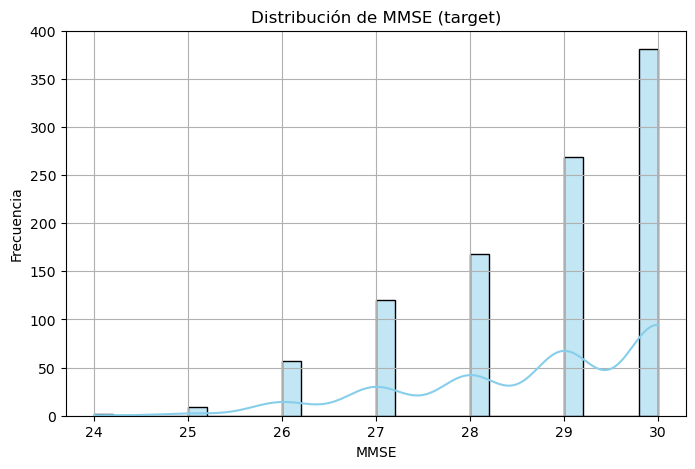

In [47]:
plt.figure(figsize=(8, 5))
sns.histplot(df_x["target"], kde=True, bins=30, color='skyblue')
plt.title("Distribución de MMSE (target)")
plt.xlabel("MMSE")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


### 1.2.2 Comparar MMSE por categorías (ej: sexo, etnicidad, etc.)

In [48]:
# Asegura que las columnas existen
if 'Sex_A1' in df_x.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_x, x="Sex_A1", y="target")
    plt.title("MMSE por Sexo")
    plt.xlabel("Sexo")
    plt.ylabel("MMSE")
    plt.show()


### 1.2.3 Outliers con boxplot

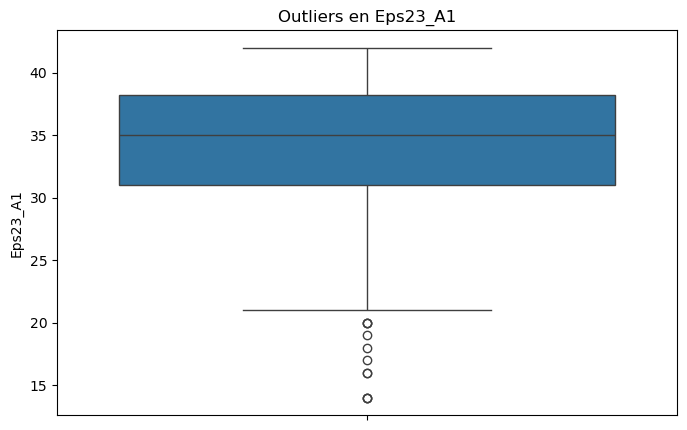

In [49]:
# Calcular correlación sólo para variables numéricas
corr_matrix = df_x.select_dtypes(include=["int64", "float64"]).corr()
# Analizar la variable numérica más correlacionada con MMSE
top_corr = corr_matrix["target"].abs().sort_values(ascending=False).head(10).index
feature = top_corr[1]  # Evitamos 'target' en posición 0

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_x, y=feature)
plt.title(f"Outliers en {feature}")
plt.show()


### 1.2.4 Pairplot de las variables más correlacionadas con MMSE

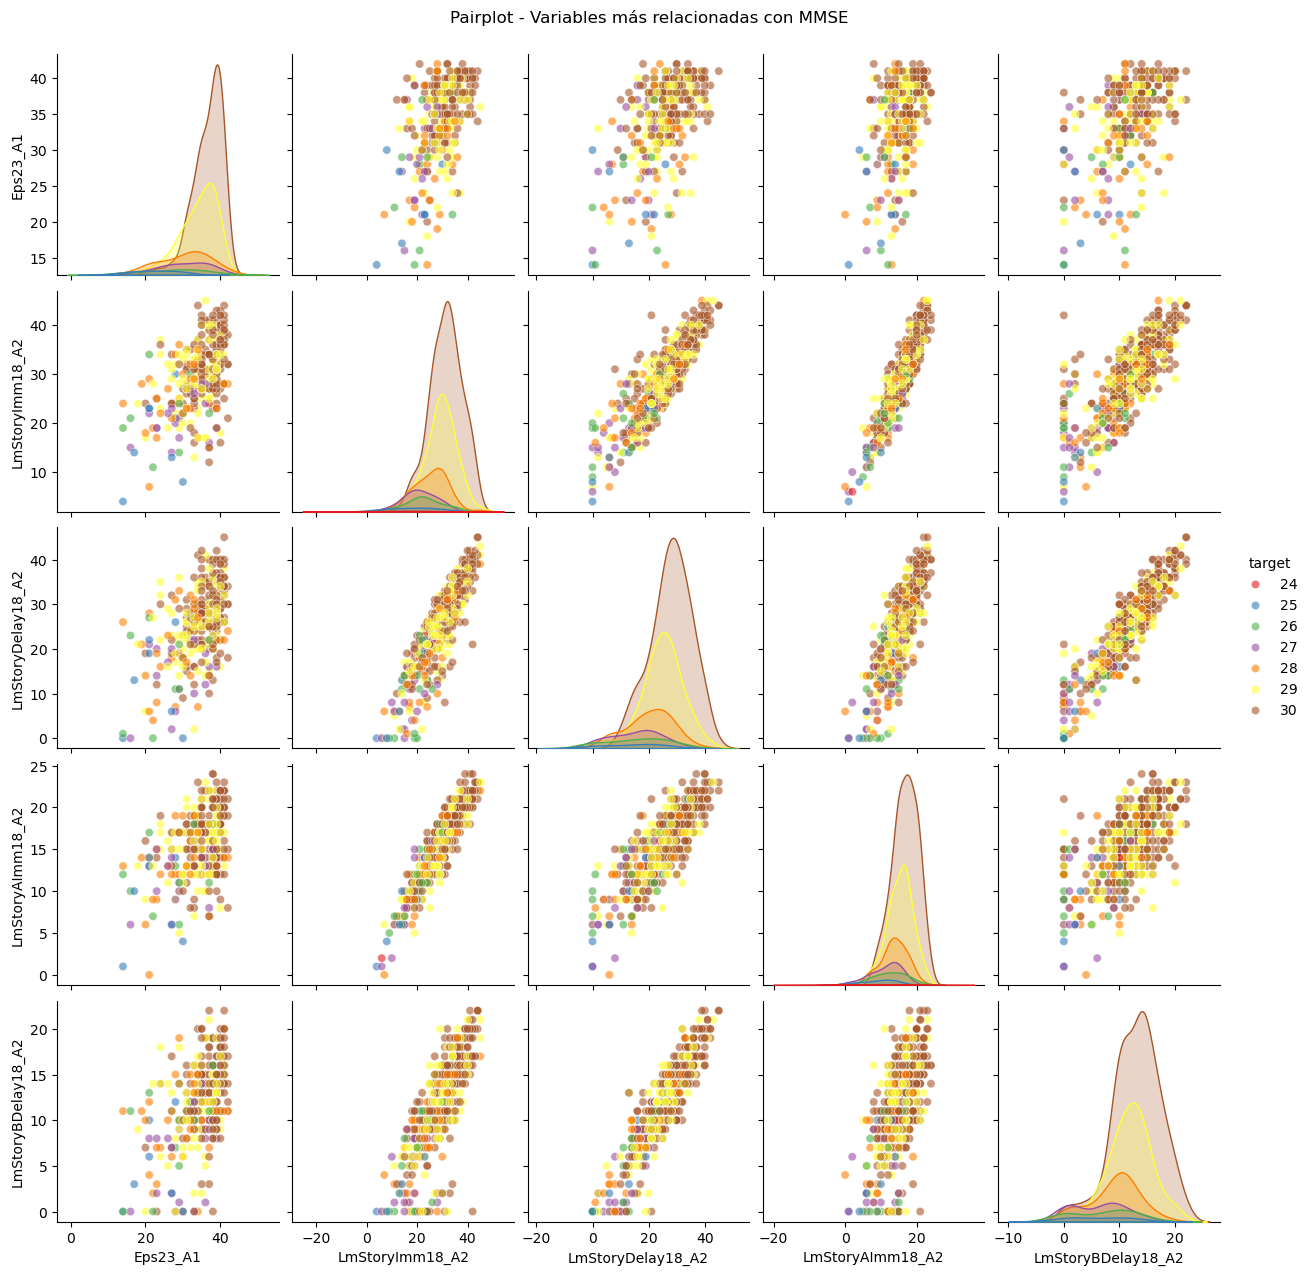

In [50]:
# Top 5 variables más correlacionadas con el target (excluyendo el mismo target)
top_vars = corr_matrix["target"].abs().sort_values(ascending=False).index[1:6].tolist()

# Subset del DataFrame solo con esas columnas + target
pair_data = df_x[top_vars + ["target"]]

sns.pairplot(pair_data, diag_kind="kde", plot_kws={"alpha": 0.6}, palette = "Set1", hue = "target")
plt.suptitle("Pairplot - Variables más relacionadas con MMSE", y=1.02)
plt.show()


### 1.2.5 Dispersión de MMSE vs una variable top

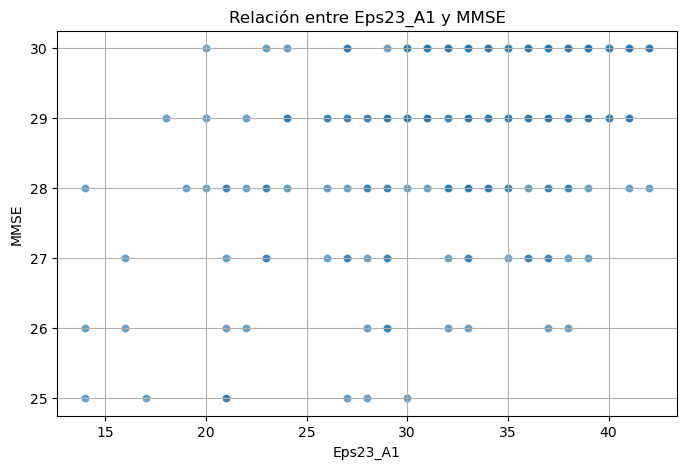

In [51]:
# Escoge la variable más correlacionada (aparte de target)
top_feature = top_vars[0]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x=top_feature, y="target", alpha=0.7)
plt.title(f"Relación entre {top_feature} y MMSE")
plt.xlabel(top_feature)
plt.ylabel("MMSE")
plt.grid(True)
plt.show()


### 1.2.6 Heatmap de valores nulos   

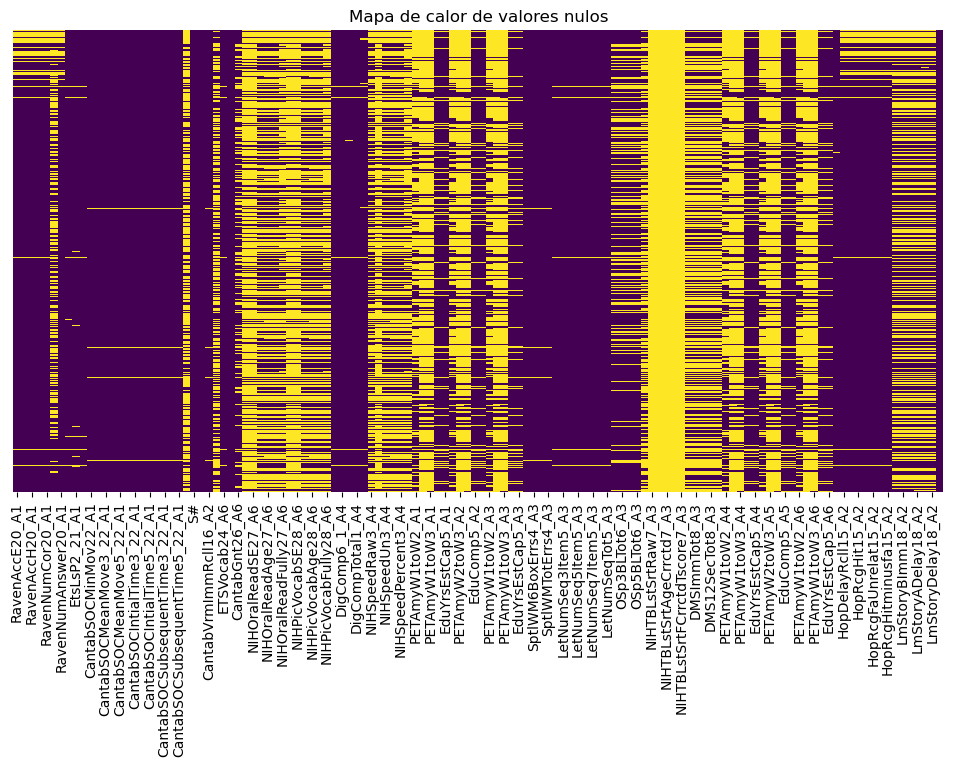

In [52]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_x.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Mapa de calor de valores nulos")
plt.show()


## 2. Preprocesamiento
---
Al finalizar el preprocesamiento se obtiene:
- df_features: Dataframe con los features validos, preprocesados y normalizados
- df_final:    Dataframe con todos los features, las columnas de identificación y la columna con el target

## 2.1. Gestión de Valores Nulos

In [53]:
umbral = 0.15
nulos = df_x.isnull().mean()

df_cols = nulos[nulos<umbral].index
df_x_nonulos = df_x[df_cols].copy()  # Columnas con Nulos por debajo del umbral
df_x_nonulos = df_x_nonulos.replace("xx", np.nan).fillna(0) # los nulos restantes se conviverten a 0

# Conversión de campos tipo object a float
object_cols = df_x_nonulos.select_dtypes(include=['object']).columns.tolist()
print(f"Columnas tipo object a convertir: {object_cols}")

# --- Conversión con manejo de errores: strings no numéricos se vuelven NaN ---
df_x_nonulos[object_cols] = df_x_nonulos[object_cols].apply(pd.to_numeric, errors='coerce')
print(df_x_nonulos.info())

#quita la mitad de valores nulos

Columnas tipo object a convertir: ['ShipVocab25_A6']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   RavenAccE20_A1                  1006 non-null   float64
 1   RavenAccM20_A1                  1006 non-null   float64
 2   RavenAccH20_A1                  1006 non-null   float64
 3   RavenAccAll20_A1                1006 non-null   float64
 4   RavenNumCor20_A1                1006 non-null   float64
 5   RavenNumAnswer20_A1             1006 non-null   float64
 6   EtsLsP1_21_A1                   1006 non-null   float64
 7   EtsLsP2_21_A1                   1006 non-null   float64
 8   EtsLsTOTAL21_A1                 1006 non-null   float64
 9   CantabSOCMinMov22_A1            1006 non-null   float64
 10  CantabSOCMeanMove2_22_A1        1006 non-null   float64
 11  CantabSOCMeanMove3_22_A1        1006 non-n

## 2.2. Normalización


In [54]:
# --- Define columnas de identificación y target ---
id_cols = ["S#", "hoja"]
target_col = ["target"]  # reemplaza con el nombre real de tu columna target

# --- Extrae por separado ---
df_ids = df_x_nonulos[id_cols].copy()
df_target = df_x_nonulos[target_col].copy()

# --- Define el DataFrame de features para transformar ---
df_features_nonulos = df_x_nonulos.drop(columns=id_cols + target_col)
# --- Inicializar StandardScaler ---
scaler = StandardScaler()

# --- Ajustar y transformar ---
np_features = scaler.fit_transform(df_features_nonulos)

df_features = pd.DataFrame(
    np_features,
    columns=df_features_nonulos.columns,
    index=df_features_nonulos.index
)

# --- Concatenar IDs + features transformadas + target ---
df_final = pd.concat([df_ids, df_features, df_target], axis=1)

# --- Verificación ---
print(df_final.head())
print()
print(df_final.columns)


   S#  hoja  RavenAccE20_A1  RavenAccM20_A1  RavenAccH20_A1  RavenAccAll20_A1  \
0  12     1       -4.097357       -3.221361       -2.154725         -3.427820   
1  12     2        0.470741        0.814204        1.015938          0.888059   
2  12     3       -0.292132        0.140264        0.262226         -0.049001   
3  21     1       -4.097357       -3.221361       -2.154725         -3.427820   
4  49     1       -4.097357       -3.221361       -2.154725         -3.427820   

   RavenNumCor20_A1  RavenNumAnswer20_A1  EtsLsP1_21_A1  EtsLsP2_21_A1  ...  \
0         -3.365083            -4.477502      -0.398050       0.550592  ...   
1          0.924323             0.276029       0.951136       1.128997  ...   
2         -0.008157             0.276029      -0.060754       0.261389  ...   
3         -3.365083            -4.477502      -0.937725      -1.618428  ...   
4         -3.365083            -4.477502      -0.600428       0.767494  ...   

   EduYrsEstCap5_A6  HopImmRcll15_A2  

## 2.3. Estadística de los Features Normalizados


Resumen estadístico de las características normalizadas:
                          mean      std
S#                     1838.16  1459.50
hoja                      1.75     0.78
RavenAccE20_A1            0.00     1.00
RavenAccM20_A1            0.00     1.00
RavenAccH20_A1            0.00     1.00
...                        ...      ...
HopRcgFaRelat15_A2        0.00     1.00
HopRcgFaUnrelat15_A2     -0.00     1.00
HopRcgFaTotal15_A2        0.00     1.00
HopRcgHitminusfa15_A2    -0.00     1.00
target                   28.76     1.29

[65 rows x 2 columns]

 -------------------------------------------------- 

DATOS NORMALIZADOS (Z-score)

Número total de muestras:		 1006
Número total de características:	 65

ESTADÍSTICAS DE LA VARIABLE OBJETIVO (target):
count    1006.000000
mean       28.757455
std         1.291695
min        24.000000
25%        28.000000
50%        29.000000
75%        30.000000
max        30.000000
Name: target, dtype: float64


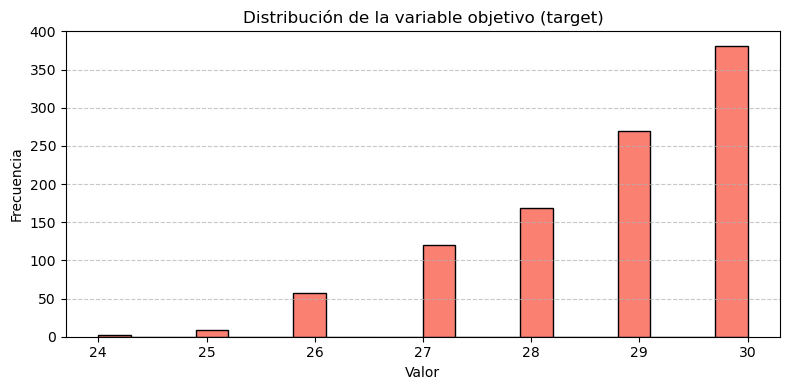

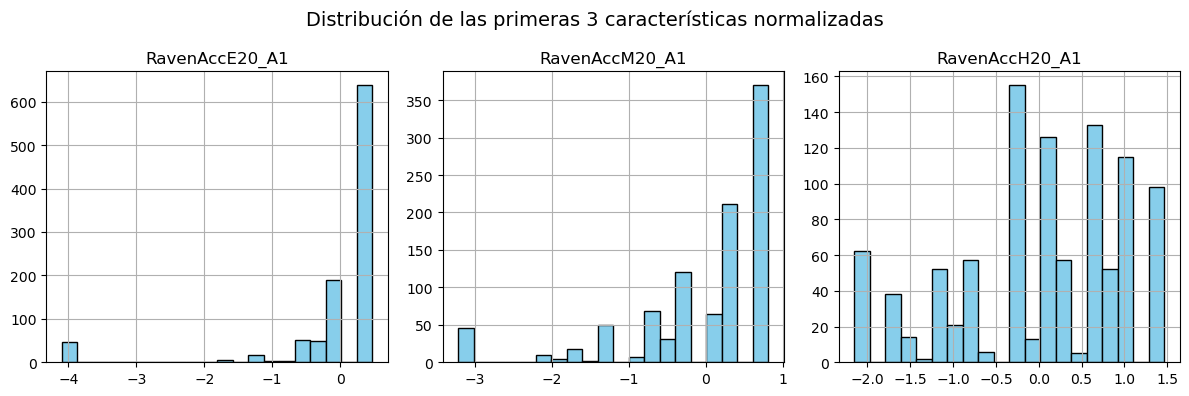

In [55]:

# Estadísticas de las features normalizadas
print('\nResumen estadístico de las características normalizadas:')
summary = df_final.describe().T[["mean", "std"]].round(2)
print(summary)

# Mostrar resumen general
print('\n', '-' * 50, '\n')
print('DATOS NORMALIZADOS (Z-score)\n')
print('Número total de muestras:\t\t', len( df_final['target']))
print('Número total de características:\t', df_final.shape[1])

# Estadísticas del target
print('\nESTADÍSTICAS DE LA VARIABLE OBJETIVO (target):')
print( df_final['target'].describe())


# Plot 1: distribución del target
plt.figure(figsize=(8, 4))
plt.hist(df_target, bins=20, color='salmon', edgecolor='black')
plt.title('Distribución de la variable objetivo (target)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: distribución de algunas variables normalizadas (primeras 3)
df_final.iloc[:, 2:5].hist(bins=20, figsize=(12, 4), layout=(1, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribución de las primeras 3 características normalizadas', fontsize=14)
plt.tight_layout()
plt.show()


## 2.4. Guardar Datos

In [56]:
df_final.to_csv('df_final.csv', index= False)


# 3. Selección de Features
---
Utilizando el dataframe df_features se obtienen seleccion de columnas en las variables:
- selected_columns_corr:  Selección de Columnas a partir de la matriz de correlación
- selected_columns_RFE:   Selección de Columnas a partir de RFE
- selected_columns_Lasso: Selección de Columnas a partir de Lasso

## 3.1 Matriz de correlación (top variables correlacionadas con MMSE)


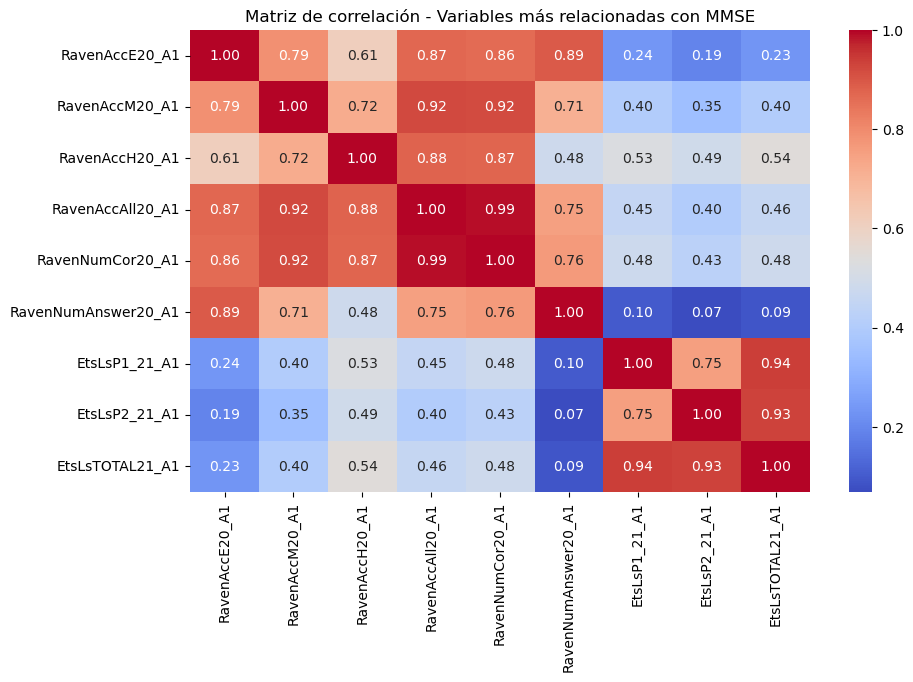

Features Seleccionados a partir de la matriz de correlación:
 Index(['RavenAccE20_A1', 'RavenAccM20_A1', 'RavenAccH20_A1',
       'RavenAccAll20_A1', 'RavenNumCor20_A1', 'RavenNumAnswer20_A1',
       'EtsLsP1_21_A1', 'EtsLsP2_21_A1', 'EtsLsTOTAL21_A1'],
      dtype='object')


In [57]:
df_matrix = pd.concat([df_features, df_final[['target']]])
corr_matrix = df_matrix.select_dtypes(include=["int64", "float64"]).corr()

# Tomar las más correlacionadas con el target
selected_columns_corr = corr_matrix["target"].abs().sort_values(ascending=False).head(10).index[1:10]

plt.figure(figsize=(10, 6))
sns.heatmap(df_features[selected_columns_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación - Variables más relacionadas con MMSE")
plt.show()
print('Features Seleccionados a partir de la matriz de correlación:\n',selected_columns_corr)


## 3.2. RFE

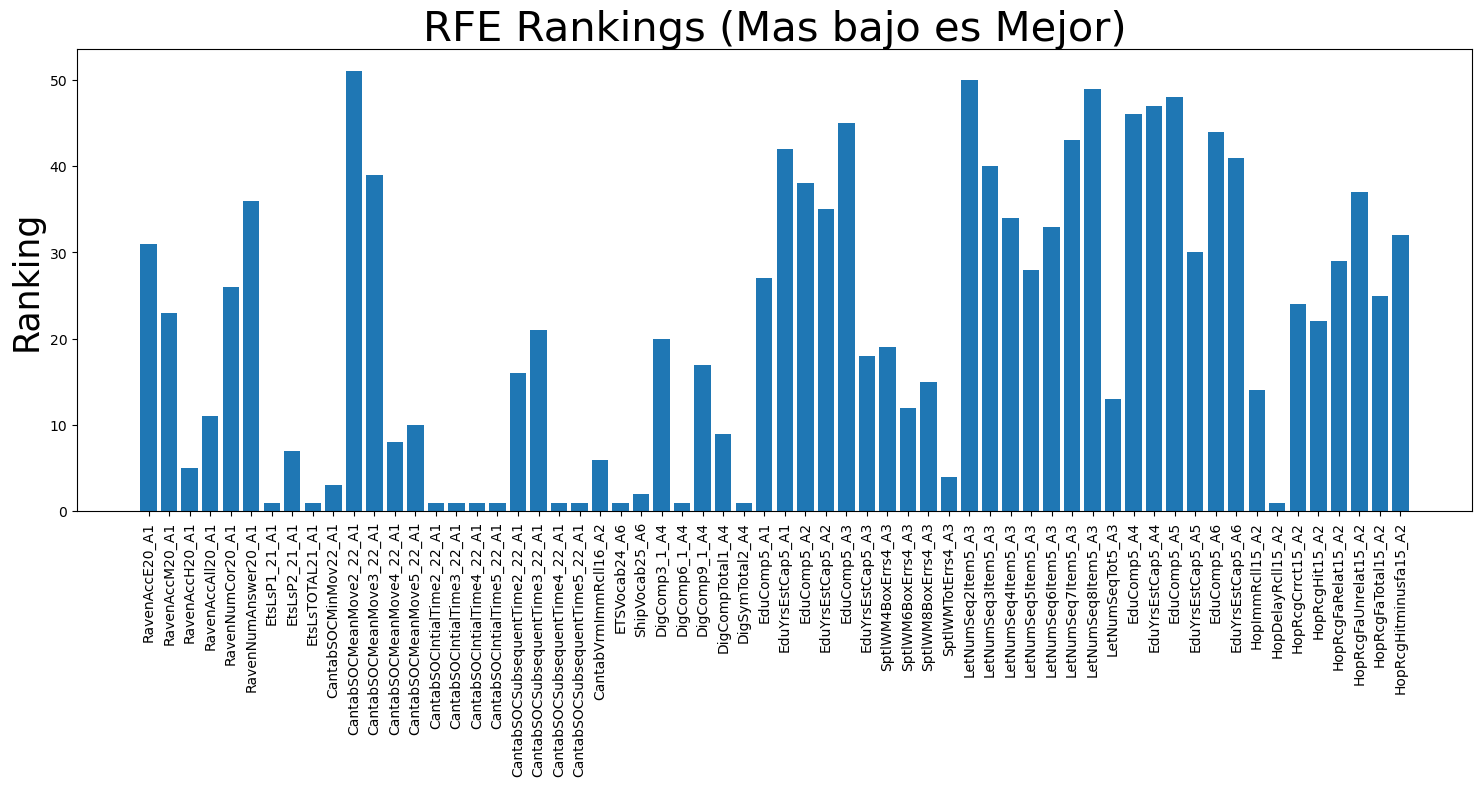


Columnas Seleccionadas por RFE:
 Index(['EtsLsP1_21_A1', 'EtsLsTOTAL21_A1', 'CantabSOCIntialTime2_22_A1',
       'CantabSOCIntialTime3_22_A1', 'CantabSOCIntialTime4_22_A1',
       'CantabSOCIntialTime5_22_A1', 'CantabSOCSubsequentTime4_22_A1',
       'CantabSOCSubsequentTime5_22_A1', 'ETSVocab24_A6', 'DigComp6_1_A4',
       'DigSymTotal2_A4', 'HopDelayRcll15_A2'],
      dtype='object')


In [59]:
# Para la selección de FEatures se utilizan todas las muestras: df_features

n_features_to_select=12

estimator = RandomForestRegressor(random_state=42)
selector = RFE(estimator, 
               n_features_to_select=n_features_to_select, 
               step=1,
               importance_getter='auto'
              )
selector = selector.fit(df_features, df_target.values.ravel())

plt.figure(figsize=(18, 6))
plt.bar(df_features.columns, selector.ranking_)
plt.title('RFE Rankings (Mas bajo es Mejor)', fontsize = 30)
plt.xticks(rotation=90, fontsize = 10)
plt.ylabel('Ranking', fontsize = 25)
plt.show()

selected_columns_RFE = df_features.columns[selector.get_support()]
features_rfe = df_features[selected_columns_RFE.tolist()]
print('\nColumnas Seleccionadas por RFE:\n',selected_columns_RFE)


## 3.3. LASSO

(1006, 62)


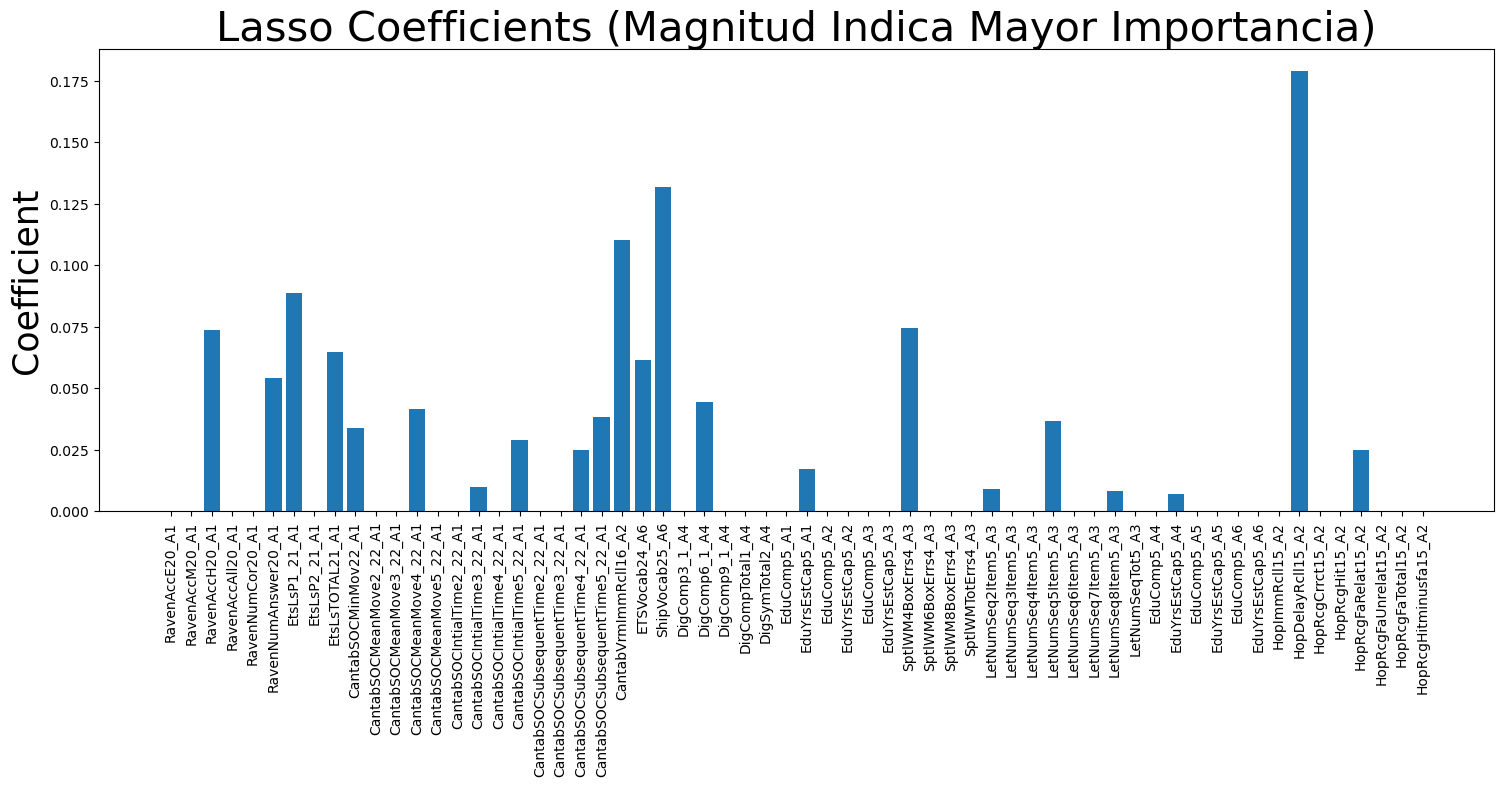


Top 10 Columnas Seleccionadas por LASSO:
 ['HopDelayRcll15_A2', 'ShipVocab25_A6', 'CantabVrmImmRcll16_A2', 'EtsLsP1_21_A1', 'SptlWM4BoxErrs4_A3', 'RavenAccH20_A1', 'EtsLsTOTAL21_A1', 'ETSVocab24_A6', 'RavenNumAnswer20_A1', 'DigComp6_1_A4']


In [60]:
##########################
#OTRO MÉTODO PARA SELECCIONAR FEATURES
######################
print(df_features.shape)
# Increase max_iter to a larger value, say 10,000
# lasso = LassoCV(cv=7, max_iter=50000000)
lasso = LassoCV(
                cv=12,
                max_iter=10000
               )

lasso.fit(df_features, df_target['target'])

plt.figure(figsize=(18, 6))
plt.bar(df_features.columns, np.abs(lasso.coef_))
plt.title('Lasso Coefficients (Magnitud Indica Mayor Importancia)', fontsize =30 )
plt.xticks(rotation=90, fontsize = 10)
plt.ylabel('Coefficient', fontsize = 25)
plt.show()

# Obtener coeficientes y su valor absoluto
coef_abs = np.abs(lasso.coef_)

# Crear un DataFrame para facilitar la selección y el ranking
coef_df = pd.DataFrame({
    'feature': df_features.columns,
    'coef': lasso.coef_,
    'coef_abs': coef_abs
})

# Ordenar de mayor a menor |coef|
coef_df_sorted = coef_df.sort_values(by='coef_abs', ascending=False)

# Seleccionar top 10
top_10 = coef_df_sorted.head(10)

selected_columns_LASSO = top_10['feature']
features_lasso = df_features[selected_columns_LASSO.tolist()]

print('\nTop 10 Columnas Seleccionadas por LASSO:\n', selected_columns_LASSO.tolist())

## 3.4. Selección Personalizada de Features

In [70]:
# CUSTOM FEATURE SELECTION
columns_MyFeatures = ['CantabVrmImmRcll16_A2',  'DigComp6_1_A4',
       'DigSymTotal2_A4', 'SptlWM4BoxErrs4_A3',
       'LetNumSeq4Item5_A3', 'LetNumSeq5Item5_A3', 'HopDelayRcll15_A2',
        'EtsLsP1_21_A1', 'EtsLsTOTAL21_A1', 'CantabSOCIntialTime2_22_A1',
       'CantabSOCIntialTime4_22_A1','CantabSOCSubsequentTime4_22_A1',
       'CantabSOCSubsequentTime5_22_A1', 'ETSVocab24_A6', 'DigComp6_1_A4',
        'HopDelayRcll15_A2', 'HopDelayRcll15_A2', 'ShipVocab25_A6',
        'CantabVrmImmRcll16_A2', 'EtsLsP1_21_A1', 'SptlWM4BoxErrs4_A3', 'RavenAccH20_A1', 
        'EtsLsTOTAL21_A1', 'ETSVocab24_A6', 'RavenNumAnswer20_A1', 'DigComp6_1_A4'
       ] 

selected_features = {
    'All Features': df_features.columns,
    'Correlation' : selected_columns_corr,
    'RFE'         : selected_columns_RFE,
    'Lasso'       : selected_columns_LASSO,
    'MyFeatures'  : columns_MyFeatures
}


# 4. Regresion
---
Para el entrenamiento se:
- Se crea division de los datos: X_train_reg, X_test_reg, y_train_reg, y_test_reg
- No se utiliza Técnicas de Balanceo de carga

## 4.1. División de Los Datos Para Regresión

Datos de Entrenamiento:  (804, 62) 	Target: (804,)
Datos de Test:  (202, 62) 	Target: (202,)


División de datos:
------------------------------
Train size: 804
Test size: 202


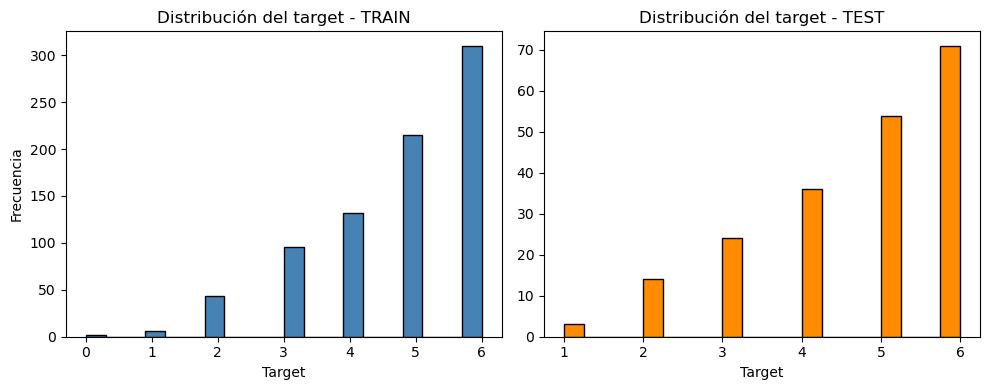

In [71]:
# División train-test
df_target_regresion = df_final['target'] - df_final['target'].min()

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    df_features, df_target_regresion, test_size=0.2, random_state=42
)

print('Datos de Entrenamiento: ', X_train_reg.shape, '\tTarget:', y_train_reg.shape)
print('Datos de Test: ', X_test_reg.shape, '\tTarget:', y_test_reg.shape)
print()
# Mostrar resumen
print("\nDivisión de datos:\n" + "-"*30)
print("Train size:", X_train_reg.shape[0])
print("Test size:", X_test_reg.shape[0])

# Verificar distribución del target
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(y_train_reg, bins=20, color="steelblue", edgecolor='black')
plt.title("Distribución del target - TRAIN")
plt.xlabel("Target")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(y_test_reg, bins=20, color="darkorange", edgecolor='black')
plt.title("Distribución del target - TEST")
plt.xlabel("Target")

plt.tight_layout()
plt.show()


## 4.2. Entrenamiento de Regresión

In [121]:
CROSS_VALIDATION = False
CV = 5

# Function to evaluate features using cross-validation
def evaluate_features(X, y, model, metric = 'mae', cross_validation = False, cv = 5):
    if cross_validation:
        scores = cross_val_score(model, X, y, cv=cv, scoring = metric)
    else:
        if metric == 'rmse':
            scores = np.sqrt(mean_squared_error(y, model.predict(X)))
        if metric == 'mae': 
            scores = np.mean(np.abs(y - model.predict(X)))

    
    return scores.mean(), scores.std()


# Create regressors
regressors = {
    "Regressor K-Neighbor": KNeighborsRegressor(n_neighbors=3),
    "Regressor Linear": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(),
    #"Support Vector Regressor": SVR(kernel="linear"),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Neural Net Regressor": MLPRegressor(alpha=1, max_iter=1000),
   # "Gaussian Process Regressor": GaussianProcessRegressor(kernel=1.0 * RBF(1.0))
}

# Store results for each feature set

results_list = {}
for name, model in regressors.items():
    results = {}

    print('\nCLASSIFIER:\t', name,'\n----------------------------------')
    for feature_name, feature_columns in selected_features.items():
        
        feature_data = X_train_reg[feature_columns]
        model.fit(feature_data, y_train_reg)
        mean_score, std_score = evaluate_features(feature_data, y_train_reg,
                                                  model,
                                                  cross_validation = CROSS_VALIDATION,
                                                  cv = CV)
        results[feature_name] = (mean_score, std_score)
        print('\t',feature_name,' RMSE:\t', mean_score)
    results_list[name] = results



CLASSIFIER:	 Regressor K-Neighbor 
----------------------------------
	 All Features  RMSE:	 0.736318407960199
	 Correlation  RMSE:	 0.7661691542288557
	 RFE  RMSE:	 0.7101990049751243
	 Lasso  RMSE:	 0.6861525704809286
	 MyFeatures  RMSE:	 0.6915422885572139

CLASSIFIER:	 Regressor Linear 
----------------------------------
	 All Features  RMSE:	 0.8829658288012964
	 Correlation  RMSE:	 0.9571293646846069
	 RFE  RMSE:	 0.9337506965561159
	 Lasso  RMSE:	 0.9162295438598299
	 MyFeatures  RMSE:	 0.9099957640424123

CLASSIFIER:	 Ridge Regression 
----------------------------------
	 All Features  RMSE:	 0.8856468410278081
	 Correlation  RMSE:	 0.9581924612222525
	 RFE  RMSE:	 0.9337734052512504
	 Lasso  RMSE:	 0.9162409168931556
	 MyFeatures  RMSE:	 0.9099952304061167

CLASSIFIER:	 Lasso Regression 
----------------------------------
	 All Features  RMSE:	 0.9451799046822833
	 Correlation  RMSE:	 0.9784315755044852
	 RFE  RMSE:	 0.960619619603814
	 Lasso  RMSE:	 0.9469289658257719
	 MyFe

## 4.3. Evaluación de la Regresion

### 4.3.1. Comparación de Resultados

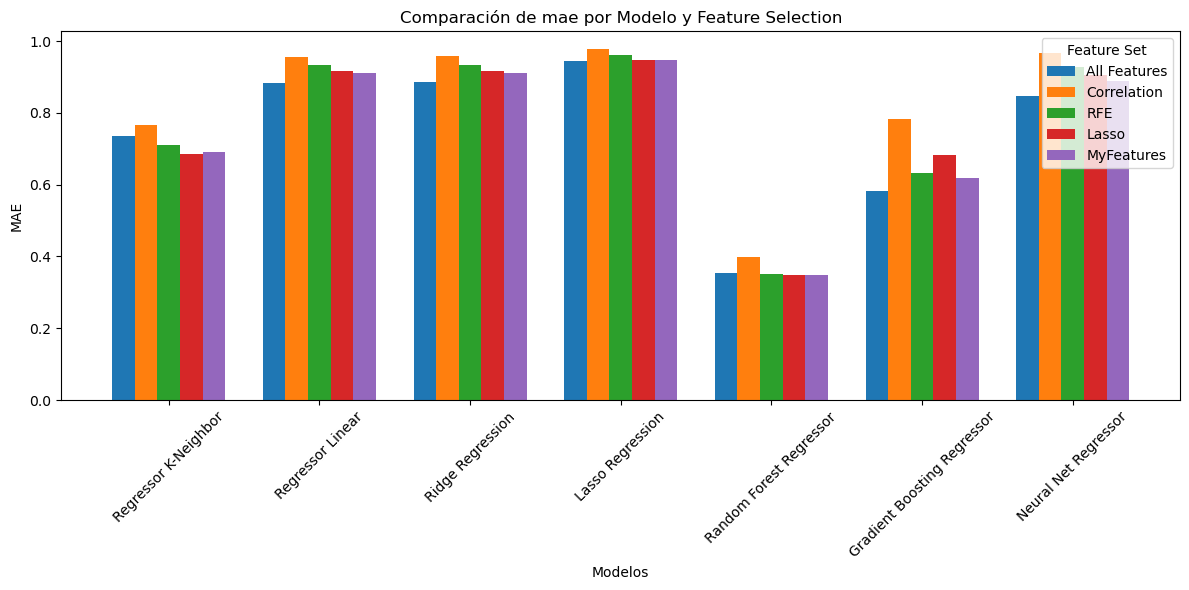

In [125]:
results_flat = []

for model_name, features_dict in results_list.items():
    for feature_name, (mean_score, std_score) in features_dict.items():
        results_flat.append( (model_name, feature_name, mean_score) )

# Crear DataFrame
df_results = pd.DataFrame(results_flat, columns=['Modelo','Feature','RMSE'])
# Lista de modelos y features
modelos = df_results['Modelo'].unique()
features = df_results['Feature'].unique()

# Configurar posiciones de barras
x = np.arange(len(modelos))
width = 0.15

plt.figure(figsize=(12,6))

# Dibujar barras por feature set desplazadas en x
for i, feature in enumerate(features):
    rmse_vals = []
    for modelo in modelos:
        value = df_results.loc[(df_results['Modelo']==modelo) & (df_results['Feature']==feature), 'RMSE']
        rmse_vals.append(value.values[0] if not value.empty else np.nan)
    
    plt.bar(x + i*width, rmse_vals, width=width, label=feature)

# Etiquetas y formato
plt.xlabel('Modelos')
plt.ylabel('MAE')
plt.title('Comparación de mae por Modelo y Feature Selection')
plt.xticks(x + width*(len(features)/2 - 0.5), modelos, rotation=45)
plt.legend(title='Feature Set')
plt.tight_layout()
plt.show()

### 4.3.2. Mejor Modelo y Mejor Selección de Features

In [75]:

min_score = float('inf')
min_model = None
min_feature = None

for model_name, result_dict in results_list.items():
    for feature_name, (mean_score, std_score) in result_dict.items():
        if mean_score < min_score:
            min_score = mean_score
            min_model = result_dict
            min_feature = feature_name
            best_model = regressors[model_name]
            best_feature = selected_features[feature_name]
            best_model_name = model_name
            best_feature_name = feature_name

print(f'\n MÍNIMO SCORE: {min_score:.4f} obtenido con MODEL: {best_model_name}, FEATURE: {best_feature_name}')



 MÍNIMO SCORE: 0.4351 obtenido con MODEL: Random Forest Regressor, FEATURE: All Features


### 4.3.3. Evaluación del Mejor Modelo

Train RMSE: 0.442161695733732
Test RMSE: 1.1956298311222027


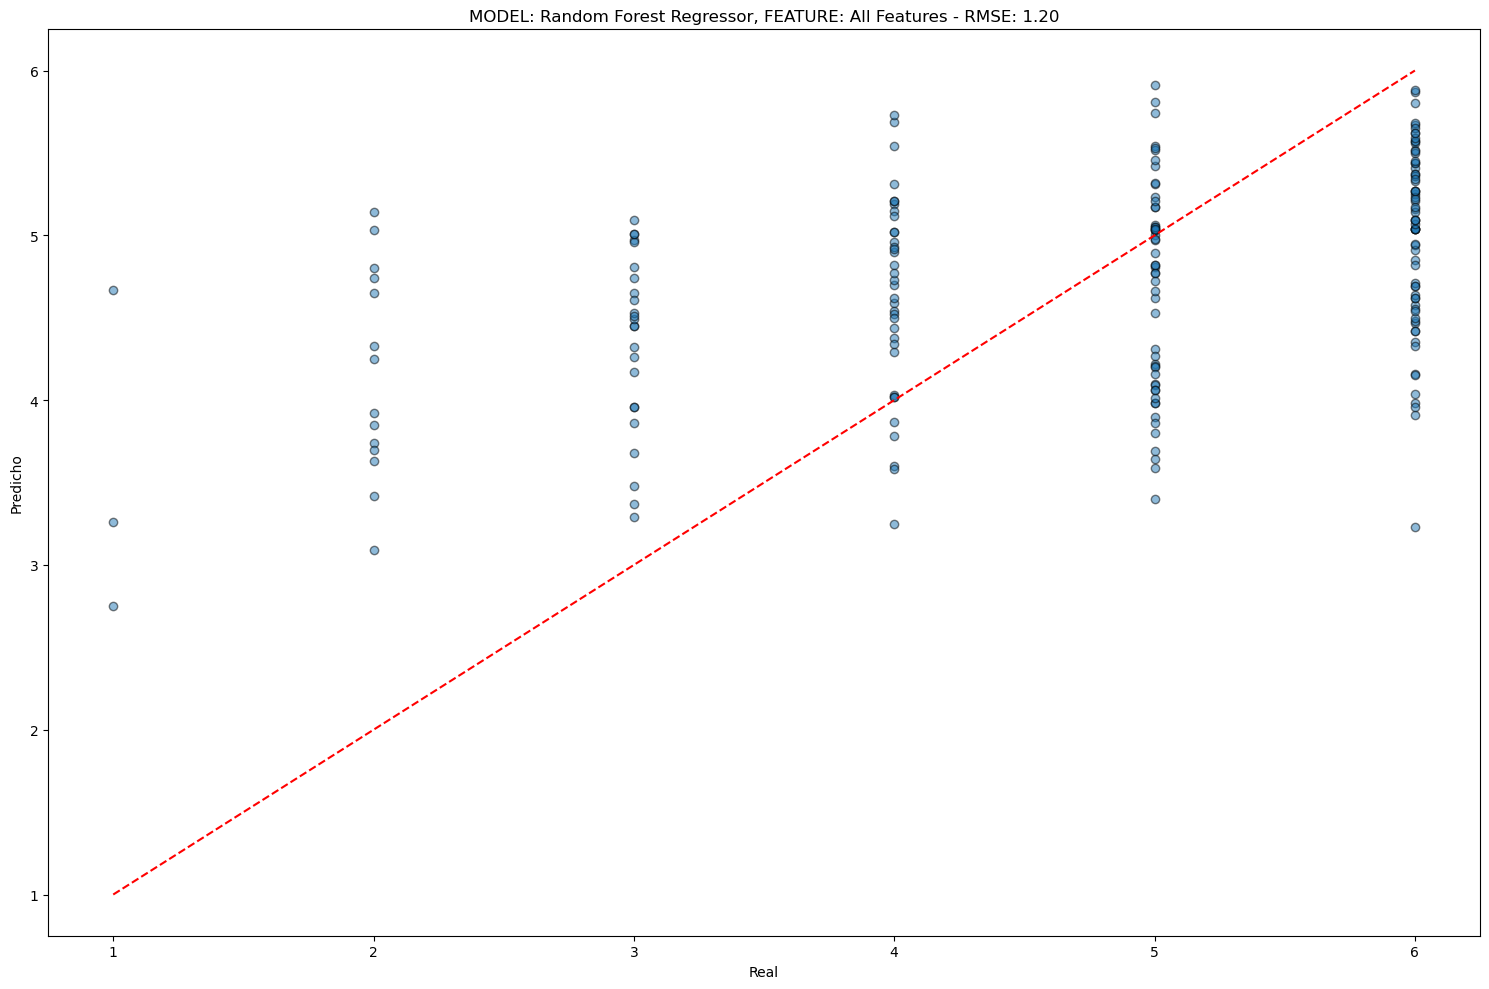

In [76]:
regressors = {
    "Regressor K-Neighbor": KNeighborsRegressor(n_neighbors=3),
    "Regressor Linear": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(),
    #"Support Vector Regressor": SVR(kernel="linear"),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Neural Net Regressor": MLPRegressor(alpha=1, max_iter=1000),
   # "Gaussian Process Regressor": GaussianProcessRegressor(kernel=1.0 * RBF(1.0))
}
X_train_eval = X_train_reg[best_feature]
X_test_eval = X_test_reg[best_feature]
model = regressors[best_model_name]

model.fit(X_train_eval, y_train_reg)
y_pred_reg = model.predict(X_train_eval)
rmse_reg_train = np.sqrt(mean_squared_error(y_train_reg, y_pred_reg))
print('Train RMSE:', rmse_reg_train)

# Evaluación
model = regressors[best_model_name]
model.fit(X_train_eval, y_train_reg)
y_pred_reg = model.predict(X_test_eval)
rmse_reg_test = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print('Test RMSE:', rmse_reg_test)
plt.figure(figsize=(15, 10))

# Graficar scatter real vs predicho
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5, edgecolors='k')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')  # Línea ideal
plt.title(f"MODEL: {best_model_name}, FEATURE: {best_feature_name} - RMSE: {rmse_reg_test:.2f}")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


# 5. Clasificación

## 5.1. Balanceo de Carga

In [77]:
df_y = df_target['target'] - df_target['target'].min()
y_binaria = [1 if x < 3 else 0 for x in df_y ]

#Aplicar SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(df_features, y_binaria)


print(f"Distribución de bins antes del SMOTE: {Counter(y_binaria)}")
print(f"Distribución de bins despues del SMOTE: {Counter(y_resampled)}\n")
print(pd.DataFrame(X_resampled.info()))
# Variables para el entremaniento dfespues de balanceo de carga:
#      df_features, df_target  -->   X_resampled, y_resampled


Distribución de bins antes del SMOTE: Counter({0: 938, 1: 68})
Distribución de bins despues del SMOTE: Counter({0: 938, 1: 938})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 62 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   RavenAccE20_A1                  1876 non-null   float64
 1   RavenAccM20_A1                  1876 non-null   float64
 2   RavenAccH20_A1                  1876 non-null   float64
 3   RavenAccAll20_A1                1876 non-null   float64
 4   RavenNumCor20_A1                1876 non-null   float64
 5   RavenNumAnswer20_A1             1876 non-null   float64
 6   EtsLsP1_21_A1                   1876 non-null   float64
 7   EtsLsP2_21_A1                   1876 non-null   float64
 8   EtsLsTOTAL21_A1                 1876 non-null   float64
 9   CantabSOCMinMov22_A1            1876 non-null   float64
 10  CantabSOCMeanMove2_22_A1  

## 5.2. División de los datos

In [78]:
# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

#y_train_clasif = (y_train - np.min(y_train)).astype(int)
#y_test_clasif = (y_test - np.min(y_test)).astype(int)

#print(y_train_clasif.shape)

print(np.unique(y_train))
print(np.unique(y_test))


[0 1]
[0 1]


## 5.3. Entrenamiento de Clasificacion

In [98]:
CROSS_VALIDATION = True
CV = 5
METRIC = 'accuracy' #se puede cambiar 
# Function to evaluate features using cross-validation
def evaluate_features_clasif(X, y, model, metric = 'accuracy', cross_validation = False, cv = 5):
    if cross_validation:
        scores = cross_val_score(model, X, y, cv=cv, scoring = metric)
    else:
        return None, None
    
    return scores.mean(), scores.std()

# Create classifiers
classifiers = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    #"Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM (Linear Kernel)": SVC(kernel="linear"),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Net": MLPClassifier(max_iter = 2000),
    #"Gaussian Process": GaussianProcessClassifier(kernel=1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()
}

# Store results for each feature set

results_clasif_list = {}
for name, model in classifiers.items():
    results_clasif = {}
    print('\nCLASSIFIER:\t', name,'\n----------------------------------')
    for feature_name, feature_columns in selected_features.items():
        feature_data = X_train[feature_columns]
        model.fit(feature_data, y_train)
        mean_score, std_score = evaluate_features_clasif(feature_data, y_train, 
                                                         model,
                                                         metric = METRIC,
                                                         cross_validation = CROSS_VALIDATION,
                                                         cv = CV
                                                        )
        results_clasif[feature_name] = (mean_score, std_score)
        print('\t',feature_name, METRIC, mean_score)
    results_clasif_list[name] = results_clasif
        



CLASSIFIER:	 K-Nearest Neighbors 
----------------------------------
	 All Features accuracy 0.8173333333333332
	 Correlation accuracy 0.8106666666666665
	 RFE accuracy 0.8346666666666668
	 Lasso accuracy 0.8753333333333332
	 MyFeatures accuracy 0.8433333333333334

CLASSIFIER:	 Ridge Classifier 
----------------------------------
	 All Features accuracy 0.7773333333333332
	 Correlation accuracy 0.7213333333333333
	 RFE accuracy 0.7120000000000001
	 Lasso accuracy 0.7273333333333334
	 MyFeatures accuracy 0.7186666666666666

CLASSIFIER:	 Random Forest 
----------------------------------
	 All Features accuracy 0.9733333333333333
	 Correlation accuracy 0.9133333333333334
	 RFE accuracy 0.9186666666666667
	 Lasso accuracy 0.938
	 MyFeatures accuracy 0.9480000000000001

CLASSIFIER:	 SVM (Linear Kernel) 
----------------------------------
	 All Features accuracy 0.7786666666666666
	 Correlation accuracy 0.7293333333333333
	 RFE accuracy 0.7213333333333334
	 Lasso accuracy 0.7186666666666667

## 5.4. Comparación de Modelos

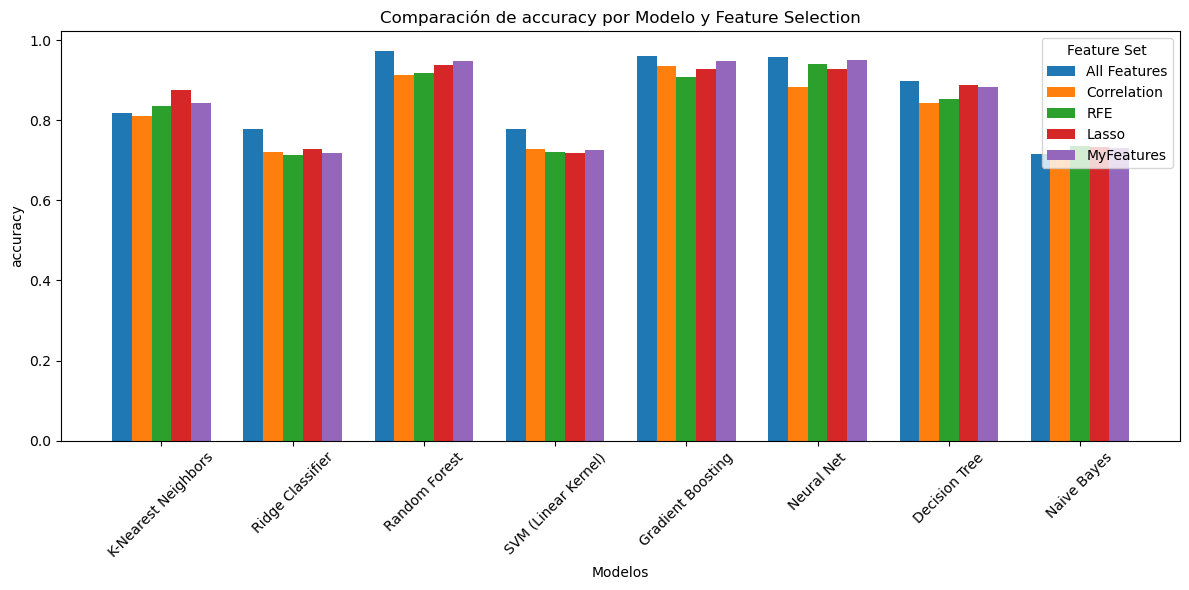

In [99]:
results_flat = []

for model_name, features_dict in results_clasif_list.items():
    for feature_name, (mean_score, std_score) in features_dict.items():
        results_flat.append( (model_name, feature_name, mean_score) )

# Crear DataFrame
df_results = pd.DataFrame(results_flat, columns=['Modelo','Feature','RMSE'])
# Lista de modelos y features
modelos = df_results['Modelo'].unique()
features = df_results['Feature'].unique()

# Configurar posiciones de barras
x = np.arange(len(modelos))
width = 0.15

plt.figure(figsize=(12,6))

# Dibujar barras por feature set desplazadas en x
for i, feature in enumerate(features):
    rmse_vals = []
    for modelo in modelos:
        value = df_results.loc[(df_results['Modelo']==modelo) & (df_results['Feature']==feature), 'RMSE']
        rmse_vals.append(value.values[0] if not value.empty else np.nan)
    
    plt.bar(x + i*width, rmse_vals, width=width, label=feature)

# Etiquetas y formato
plt.xlabel('Modelos')
plt.ylabel(METRIC)
plt.title(f'Comparación de {METRIC} por Modelo y Feature Selection')
plt.xticks(x + width*(len(features)/2 - 0.5), modelos, rotation=45)
plt.legend(title='Feature Set')
plt.tight_layout()
plt.show()

## 5.4. Seleccion de Modelo y Features

In [100]:

min_score = 0
min_model = None
min_feature = None

for model_name, result_dict in results_clasif_list.items():
    for feature_name, (mean_score, std_score) in result_dict.items():
        if mean_score > min_score:
            min_score = mean_score
            min_model = result_dict
            min_feature = feature_name
            best_model = classifiers[model_name]
            best_feature = selected_features[feature_name]
            best_model_name = model_name
            best_feature_name = feature_name

print(f'\n MÍNIMO SCORE: {min_score:.4f} obtenido con MODEL: {best_model_name}, FEATURE: {best_feature_name}')

X_train_best = X_train[selected_features[best_feature_name]]
X_test_best = X_test[selected_features[best_feature_name]]
model_best = classifiers[best_model_name]


 MÍNIMO SCORE: 0.9733 obtenido con MODEL: Random Forest, FEATURE: All Features


## 5.7. Evaluación Sin Optuna

Accuracy: 0.955
Recall: 0.955
AUROC: 0.955


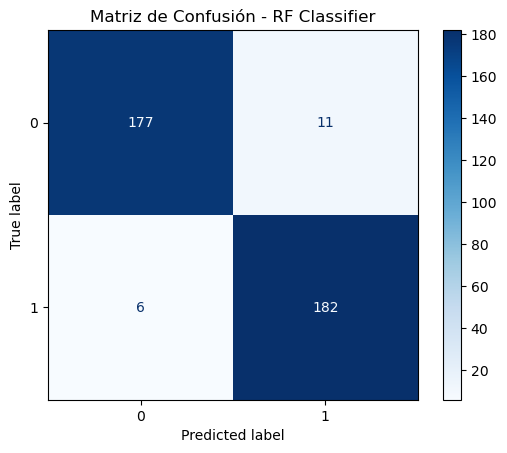

In [101]:
model = classifiers[best_model_name]
selected_columns = selected_features[feature_name]
#model = classifiers['Neural Net']
#selected_columns = selected_features['All Features']

X_train_eval = X_train[selected_columns]
X_test_eval = X_test[selected_columns]

# Entrenamiento
model.fit(X_train_eval, y_train)

# Predicción
y_pred = model.predict(X_test_eval)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  # Usa 'macro' o 'weighted' si es multiclase
try:
    auroc = roc_auc_score(y_test, y_pred)
except:
    auroc = None  # En caso de que no se pueda calcular (por ejemplo, si es multiclase sin ajuste)

cm = confusion_matrix(y_test, y_pred)

# Guardar resultados
results["MLP Classifier"] = {
    "Accuracy": accuracy,
    "Recall": recall,
    "AUROC": auroc
}

# Mostrar métricas
print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
if auroc is not None:
    print(f"AUROC: {auroc:.3f}")
else:
    print("AUROC: No disponible (verifica si es un problema binario).")

# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - RF Classifier")
plt.show()


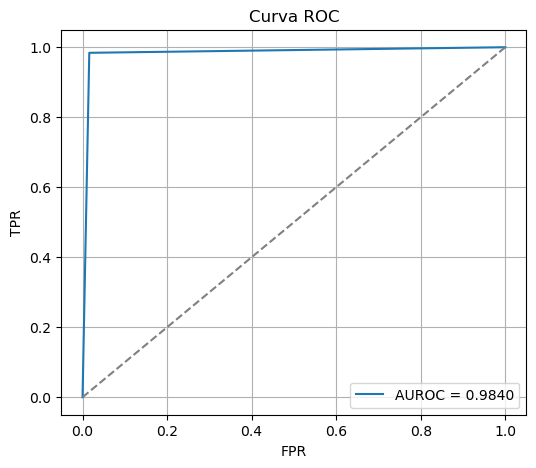

In [116]:
def curva_auroc(y_test, y_pred, auroc):    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    #auroc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

curva_auroc(y_test, y_pred, auroc)

## 5.6. Optimización del Modelo con Optuna

### 5.6.1. Instalación de la librería Optuna

In [103]:
!pip install optuna

### 5.6.2. Aplicación de Optuna al mejor Modelo y mejor Selección de Features

[I 2025-07-14 20:33:53,734] A new study created in memory with name: no-name-35a60190-2be2-437a-9c81-5c1c0db8bbbf
[I 2025-07-14 20:33:55,034] Trial 0 finished with value: 0.95 and parameters: {'n_estimators': 234, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.95.
[I 2025-07-14 20:33:56,056] Trial 1 finished with value: 0.7973333333333333 and parameters: {'n_estimators': 191, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.95.
[I 2025-07-14 20:33:56,568] Trial 2 finished with value: 0.9099999999999999 and parameters: {'n_estimators': 68, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.95.
[I 2025-07-14 20:33:57,157] Trial 3 finished with value: 0.9466666666666667 and parameters: {'n_estimators': 87, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features'

Mejores parámetros (Clasificación): {'n_estimators': 230, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Accuracy: 0.984
Recall: 0.984
AUROC: 0.984


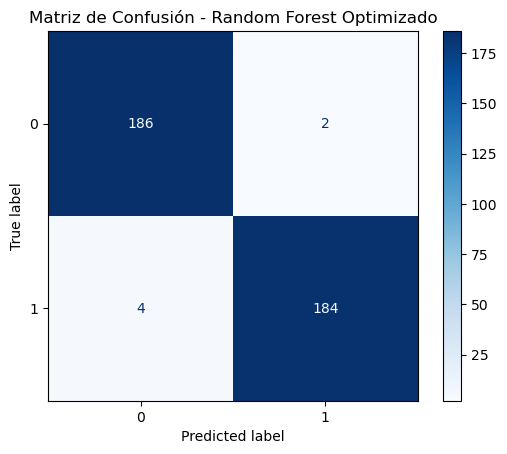

In [117]:
# ---------- 1. OPTUNA ----------
def objective_classification(trial):
    clf = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 2, 40),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state=42,
        n_jobs=-1
    )
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

study_cls = optuna.create_study(direction="maximize")
study_cls.optimize(objective_classification, n_trials=50)

# ---------- 2. EXTRAER PARÁMETROS ----------
print("Mejores parámetros (Clasificación):", study_cls.best_params)

# ---------- 3. ENTRENAMIENTO DEL MODELO ----------
model = RandomForestClassifier(**study_cls.best_params,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_best, y_train)
y_pred = model.predict(X_test_best)

# ---------- 4. EVALUACIÓN ----------
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')

try:
    auroc = roc_auc_score(y_test, y_pred)
except:
    auroc = None

cm = confusion_matrix(y_test, y_pred)

results["Random Forest Optuna"] = {
    "Accuracy": accuracy,
    "Recall": recall,
    "AUROC": auroc
}

# Mostrar métricas
print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
if auroc is not None:
    print(f"AUROC: {auroc:.3f}")
else:
    print("AUROC: No disponible (verifica si es un problema binario).")

# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.show()


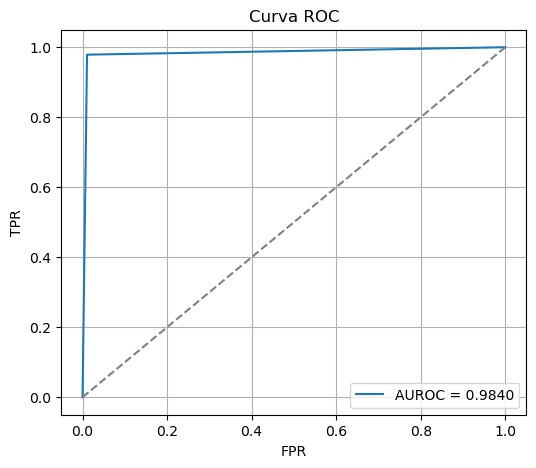

In [119]:
curva_auroc(y_test, y_pred, auroc )

# 6. Guardar el modelo

In [106]:
# Guardar modelo
model_save = {
    'model'   : model,
    'features': selected_features[best_feature_name]
}

joblib.dump(model_save, 'best_model_clasifier.pkl')

['best_model_clasifier.pkl']

In [107]:
selected_features[best_feature_name]

Index(['RavenAccE20_A1', 'RavenAccM20_A1', 'RavenAccH20_A1',
       'RavenAccAll20_A1', 'RavenNumCor20_A1', 'RavenNumAnswer20_A1',
       'EtsLsP1_21_A1', 'EtsLsP2_21_A1', 'EtsLsTOTAL21_A1',
       'CantabSOCMinMov22_A1', 'CantabSOCMeanMove2_22_A1',
       'CantabSOCMeanMove3_22_A1', 'CantabSOCMeanMove4_22_A1',
       'CantabSOCMeanMove5_22_A1', 'CantabSOCIntialTime2_22_A1',
       'CantabSOCIntialTime3_22_A1', 'CantabSOCIntialTime4_22_A1',
       'CantabSOCIntialTime5_22_A1', 'CantabSOCSubsequentTime2_22_A1',
       'CantabSOCSubsequentTime3_22_A1', 'CantabSOCSubsequentTime4_22_A1',
       'CantabSOCSubsequentTime5_22_A1', 'CantabVrmImmRcll16_A2',
       'ETSVocab24_A6', 'ShipVocab25_A6', 'DigComp3_1_A4', 'DigComp6_1_A4',
       'DigComp9_1_A4', 'DigCompTotal1_A4', 'DigSymTotal2_A4', 'EduComp5_A1',
       'EduYrsEstCap5_A1', 'EduComp5_A2', 'EduYrsEstCap5_A2', 'EduComp5_A3',
       'EduYrsEstCap5_A3', 'SptlWM4BoxErrs4_A3', 'SptlWM6BoxErrs4_A3',
       'SptlWM8BoxErrs4_A3', 'SptlWMTotEr